In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [93]:
# Load & Inspect Data
df = pd.read_csv("customer_journey.csv")
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12719 entries, 0 to 12718
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SessionID           12719 non-null  object
 1   UserID              12719 non-null  object
 2   Timestamp           12719 non-null  object
 3   PageType            12719 non-null  object
 4   DeviceType          12719 non-null  object
 5   Country             12719 non-null  object
 6   ReferralSource      12719 non-null  object
 7   TimeOnPage_seconds  12719 non-null  int64 
 8   ItemsInCart         12719 non-null  int64 
 9   Purchased           12719 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 993.8+ KB


SessionID             0
UserID                0
Timestamp             0
PageType              0
DeviceType            0
Country               0
ReferralSource        0
TimeOnPage_seconds    0
ItemsInCart           0
Purchased             0
dtype: int64

In [94]:
# Sort Journey Correctly
df = df.sort_values(
    by=['UserID', 'SessionID', 'PageType']
)

In [95]:
# Combine steps into a single path
path_df = (
    df.groupby(['UserID', 'SessionID'])['PageType']
    .apply(lambda x: ' → '.join(x))
    .reset_index(name='purchase_path')
)

In [96]:
# Find Most Common Purchase Paths
path_counts = path_df['purchase_path'].value_counts().head(10)
path_counts

purchase_path
home → product_page                                     2388
home                                                    1013
cart → checkout → confirmation → home → product_page    1010
cart → home → product_page                               476
cart → checkout → home → product_page                    113
Name: count, dtype: int64

**Journey Length Analysis**

In [97]:
#  Plot Journey Length Distribution
journey_length = df.groupby(['UserID', 'SessionID']).size()
journey_length.describe()

count    5000.00000
mean        2.54380
std         1.38234
min         1.00000
25%         2.00000
50%         2.00000
75%         3.00000
max         5.00000
dtype: float64

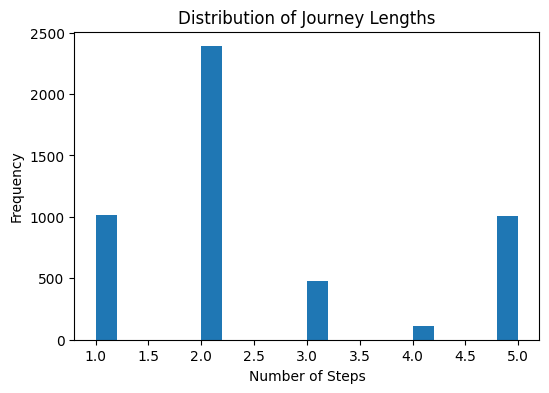

In [98]:
plt.figure(figsize=(6,4))
journey_length.plot(kind='hist', bins=20)
plt.title("Distribution of Journey Lengths")
plt.xlabel("Number of Steps")
plt.show()

**Drop-Off Pattern Detection**

In [99]:
# Count exits per page
last_steps = (
    df.groupby(['UserID', 'SessionID'])
      .last()
)

dropoff_counts = last_steps['PageType'].value_counts().head(10)
dropoff_counts


PageType
product_page    3987
home            1013
Name: count, dtype: int64

**Conversion Path Comparision**

In [100]:
# Separate purchase vs non-purchase sessions
# A
purchase_sessions = df[df['Purchased'] == 1]['SessionID'].unique()
df['converted'] = np.where(
    df['SessionID'].isin(purchase_sessions), 1, 0
)

# B
df.groupby('converted')['Timestamp'].max()


converted
0    2025-08-31 23:51:09
1    2025-08-31 22:50:00
Name: Timestamp, dtype: object

In [101]:
#  Transition Pattern Analysis
df['next_page'] = df.groupby(
    ['UserID', 'SessionID']
)['PageType'].shift(-1)

transition_counts = (
    df.dropna()
      .groupby(['PageType', 'next_page'])
      .size()
      .sort_values(ascending=False)
      .head(10)
)
transition_counts


PageType      next_page   
home          product_page    3987
cart          checkout        1123
confirmation  home            1010
checkout      confirmation    1010
cart          home             476
checkout      home             113
dtype: int64

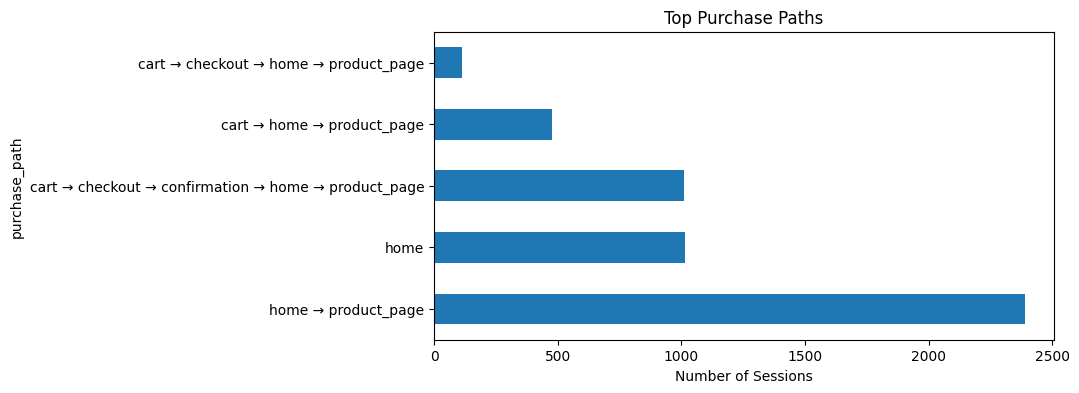

In [102]:
# Visual: Top Purchase Paths
plt.figure(figsize=(8,4))
path_counts.plot(kind='barh')
plt.title("Top Purchase Paths")
plt.xlabel("Number of Sessions")
plt.show()